# GARCH Simulation Example

This notebook demonstrates the GARCH simulation capabilities by generating 5 scenarios over 200 timesteps.

## Setup

We'll use the GJR-GARCH model with Hansen's skewed t-distribution for the innovations.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from density_engine.garch import GJRGARCH_torch
from density_engine.skew_student_t import HansenSkewedT_torch

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# GARCH parameters
mu = 0.0005      # Mean return
omega = 0.0001   # Base variance
alpha = 0.05     # ARCH coefficient
gamma = 0.03     # GJR asymmetry coefficient
beta = 0.90      # GARCH coefficient
sigma0_sq = 0.0004  # Initial variance

# Hansen's skewed t-distribution parameters
eta = 5.0        # Degrees of freedom
lam = -0.1       # Skewness parameter

# Create the distribution
dist = HansenSkewedT_torch(eta=eta, lam=lam)

# Create GARCH model
garch = GJRGARCH_torch(
    mu=mu,
    omega=omega,
    alpha=alpha,
    gamma=gamma,
    beta=beta,
    sigma0_sq=sigma0_sq,
    dist=dist
)

print("GARCH Model Parameters:")
print(f"  Mean return (μ): {mu}")
print(f"  Base variance (ω): {omega}")
print(f"  ARCH coefficient (α): {alpha}")
print(f"  GJR coefficient (γ): {gamma}")
print(f"  GARCH coefficient (β): {beta}")
print(f"  Initial variance (σ₀²): {sigma0_sq}")
print(f"  Skewed t parameters: η={eta}, λ={lam}")
print(f"  Stationarity check: κ = α + β + γ·P₀ = {garch.kappa:.4f} < 1.0")


GARCH Model Parameters:
  Mean return (μ): 0.0005
  Base variance (ω): 0.0001
  ARCH coefficient (α): 0.05
  GJR coefficient (γ): 0.03
  GARCH coefficient (β): 0.9
  Initial variance (σ₀²): 0.0004
  Skewed t parameters: η=5.0, λ=-0.1
  Stationarity check: κ = α + β + γ·P₀ = 0.9662 < 1.0


In [2]:
# Simulation parameters
num_scenarios = 5
num_timesteps = 200

# Initialize the GARCH model
garch.reset(num_scenarios)

# Store results
returns = np.zeros((num_timesteps, num_scenarios))
volatilities = np.zeros((num_timesteps, num_scenarios))
cumulative_returns = np.zeros((num_timesteps, num_scenarios))

# Run simulation
for t in range(num_timesteps):
    cum_ret, current_t = garch.step()
    
    # Store cumulative returns
    cumulative_returns[t] = cum_ret.detach().cpu().numpy()
    
    # Store volatilities (standard deviation)
    volatilities[t] = torch.sqrt(garch.var).detach().cpu().numpy()
    
    # Calculate period returns (difference from previous cumulative return)
    if t == 0:
        returns[t] = cum_ret.detach().cpu().numpy()
    else:
        returns[t] = cum_ret.detach().cpu().numpy() - cumulative_returns[t-1]

print(f"Simulation completed: {num_scenarios} scenarios over {num_timesteps} timesteps")
print(f"Final cumulative returns: {cumulative_returns[-1]}")
print(f"Average final volatility: {np.mean(volatilities[-1]):.4f}")


Simulation completed: 5 scenarios over 200 timesteps
Final cumulative returns: [ 0.4681012   0.12578101 -0.61098206 -0.33176395  0.93684697]
Average final volatility: 0.0469


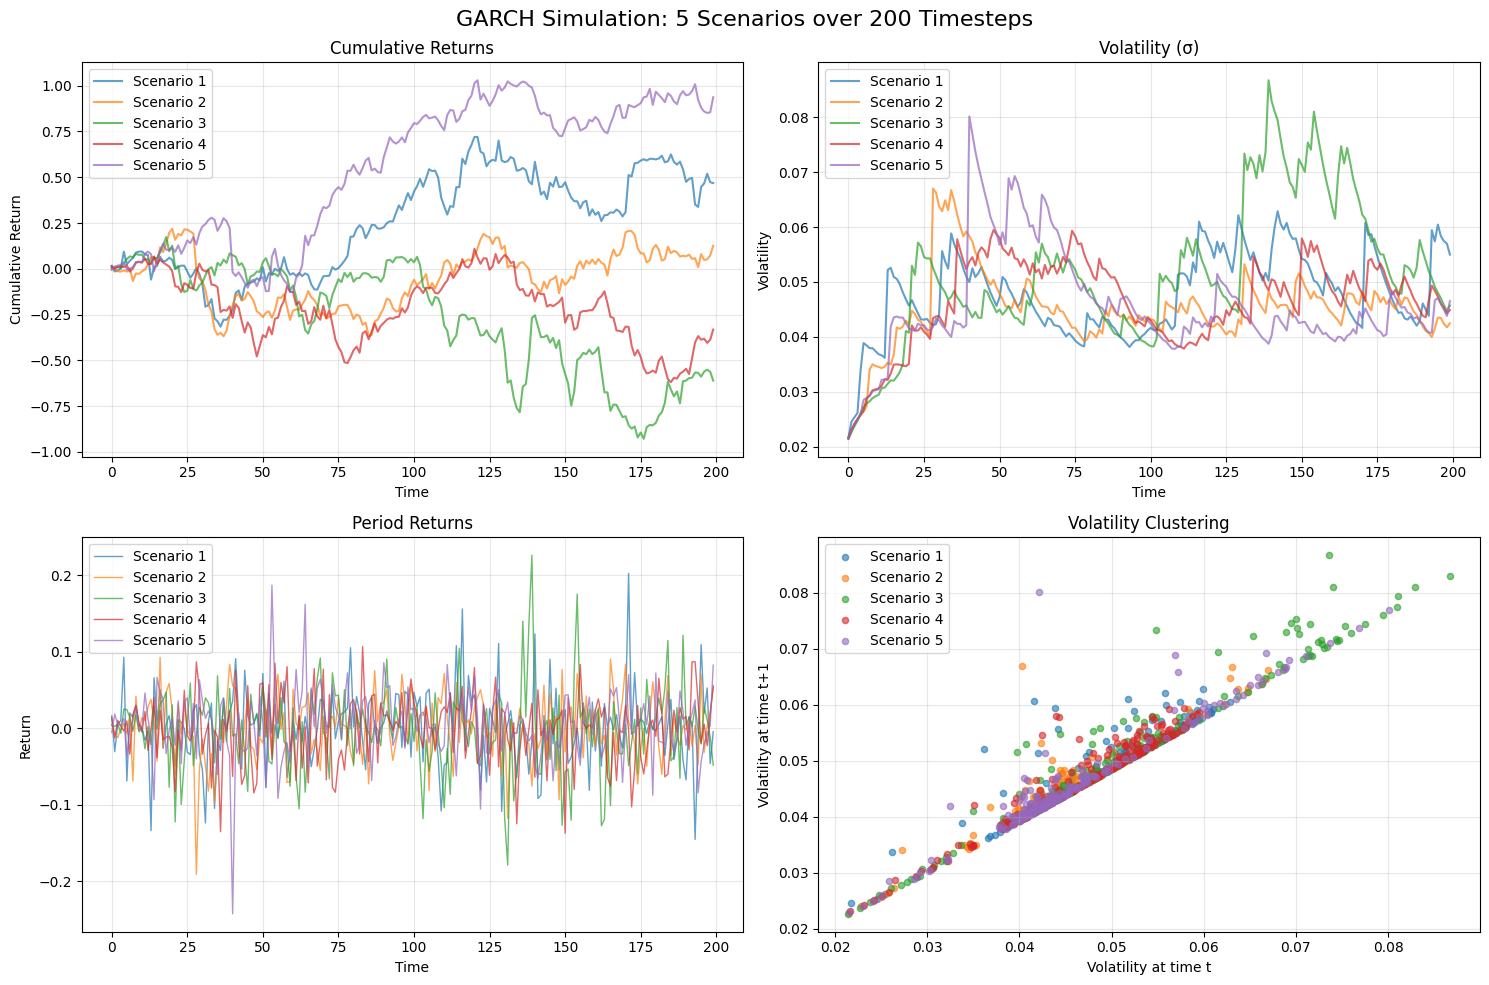

In [3]:
# Create comprehensive plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('GARCH Simulation: 5 Scenarios over 200 Timesteps', fontsize=16)

# Plot 1: Cumulative Returns
ax1 = axes[0, 0]
for i in range(num_scenarios):
    ax1.plot(cumulative_returns[:, i], alpha=0.7, linewidth=1.5, label=f'Scenario {i+1}')
ax1.set_title('Cumulative Returns')
ax1.set_xlabel('Time')
ax1.set_ylabel('Cumulative Return')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot 2: Volatility (Standard Deviation)
ax2 = axes[0, 1]
for i in range(num_scenarios):
    ax2.plot(volatilities[:, i], alpha=0.7, linewidth=1.5, label=f'Scenario {i+1}')
ax2.set_title('Volatility (σ)')
ax2.set_xlabel('Time')
ax2.set_ylabel('Volatility')
ax2.grid(True, alpha=0.3)
ax2.legend()

# Plot 3: Period Returns
ax3 = axes[1, 0]
for i in range(num_scenarios):
    ax3.plot(returns[:, i], alpha=0.7, linewidth=1.0, label=f'Scenario {i+1}')
ax3.set_title('Period Returns')
ax3.set_xlabel('Time')
ax3.set_ylabel('Return')
ax3.grid(True, alpha=0.3)
ax3.legend()

# Plot 4: Volatility Clustering (Volatility vs Lagged Volatility)
ax4 = axes[1, 1]
for i in range(num_scenarios):
    ax4.scatter(volatilities[:-1, i], volatilities[1:, i], alpha=0.6, s=20, label=f'Scenario {i+1}')
ax4.set_title('Volatility Clustering')
ax4.set_xlabel('Volatility at time t')
ax4.set_ylabel('Volatility at time t+1')
ax4.grid(True, alpha=0.3)
ax4.legend()

plt.tight_layout()
plt.show()


\nDemonstrating the path() method:
Time points: [50, 100, 150, 200]
Path results shape: torch.Size([4, 5])
Cumulative returns at each time point:
  Time  50: [-0.21735099  0.07797133  0.00705538  0.07593257  0.25793496]
  Time 100: [-0.1752112  -0.02551274  0.32254842 -0.47114033  0.02063624]
  Time 150: [-0.30503017 -0.11993571 -0.17596115 -0.2897542   1.0334433 ]
  Time 200: [-0.30310985  0.18927404 -0.40359578 -0.19769347  0.5815947 ]


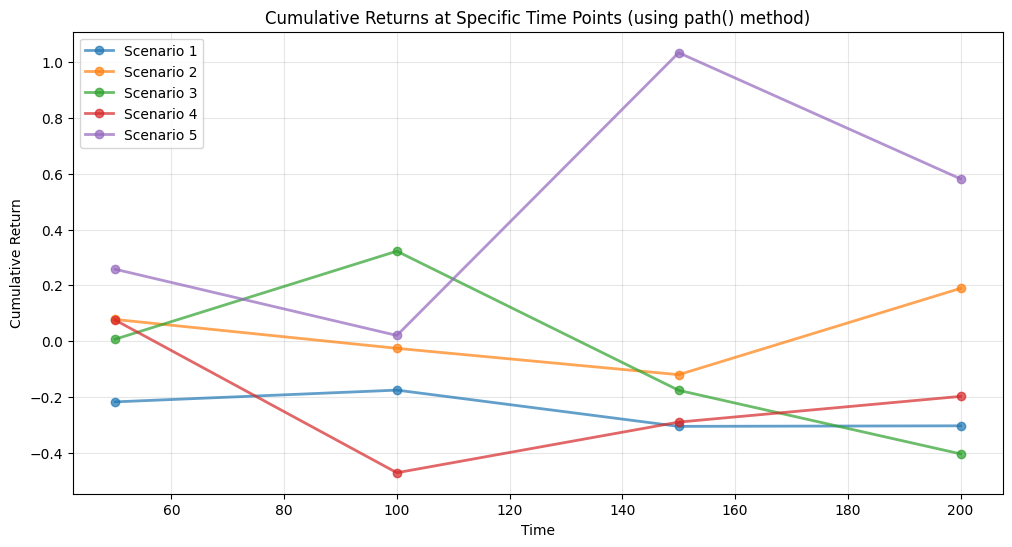

In [4]:
# Demonstrate the path() method
print("\\nDemonstrating the path() method:")
print("=" * 50)

# Reset for path demonstration
garch.reset(num_scenarios)

# Use path() method to get cumulative returns at specific time points
time_points = [50, 100, 150, 200]
path_results = garch.path(time_points)

print(f"Time points: {time_points}")
print(f"Path results shape: {path_results.shape}")
print("Cumulative returns at each time point:")
for i, t in enumerate(time_points):
    print(f"  Time {t:3d}: {path_results[i].detach().cpu().numpy()}")

# Plot the path results
plt.figure(figsize=(12, 6))
for i in range(num_scenarios):
    plt.plot(time_points, path_results[:, i].detach().cpu().numpy(), 
             'o-', alpha=0.7, linewidth=2, markersize=6, label=f'Scenario {i+1}')

plt.title('Cumulative Returns at Specific Time Points (using path() method)')
plt.xlabel('Time')
plt.ylabel('Cumulative Return')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


In [5]:
# Summary statistics
print("\\nSummary Statistics:")
print("=" * 50)

# Calculate summary statistics across all scenarios
final_returns = cumulative_returns[-1]
avg_volatility = np.mean(volatilities, axis=0)
max_drawdown = np.min(cumulative_returns - np.maximum.accumulate(cumulative_returns, axis=0), axis=0)

print(f"Final cumulative returns:")
for i, ret in enumerate(final_returns):
    print(f"  Scenario {i+1}: {ret:.4f}")

print(f"\\nAverage volatility per scenario:")
for i, vol in enumerate(avg_volatility):
    print(f"  Scenario {i+1}: {vol:.4f}")

print(f"\\nMaximum drawdown per scenario:")
for i, dd in enumerate(max_drawdown):
    print(f"  Scenario {i+1}: {dd:.4f}")

print(f"\\nOverall statistics:")
print(f"  Mean final return: {np.mean(final_returns):.4f}")
print(f"  Std final return: {np.std(final_returns):.4f}")
print(f"  Mean volatility: {np.mean(avg_volatility):.4f}")
print(f"  Mean max drawdown: {np.mean(max_drawdown):.4f}")


\nSummary Statistics:
Final cumulative returns:
  Scenario 1: 0.4681
  Scenario 2: 0.1258
  Scenario 3: -0.6110
  Scenario 4: -0.3318
  Scenario 5: 0.9368
\nAverage volatility per scenario:
  Scenario 1: 0.0477
  Scenario 2: 0.0451
  Scenario 3: 0.0516
  Scenario 4: 0.0466
  Scenario 5: 0.0456
\nMaximum drawdown per scenario:
  Scenario 1: -0.4598
  Scenario 2: -0.5873
  Scenario 3: -1.1017
  Scenario 4: -0.7281
  Scenario 5: -0.4063
\nOverall statistics:
  Mean final return: 0.1176
  Std final return: 0.5526
  Mean volatility: 0.0473
  Mean max drawdown: -0.6566
